<a href="https://colab.research.google.com/github/Hamza-333/Image_Segmentation/blob/main/CSC420_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models, torchvision.datasets
from torch.utils.data import Dataset
from torchvision.io import read_image
import os
import shutil
import random
import matplotlib.pyplot as plt

# Data Preparation

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
example_clothing = read_image("/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/labels_clothing/0001_clothes.png")
example_person = read_image("/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/labels_person/0001_person.png")

In [4]:
example_img = read_image("/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/images/0001.jpg")

torch.Size([1, 600, 400])


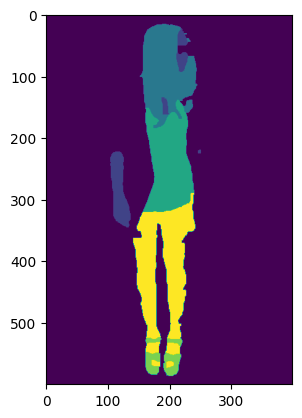

In [5]:
#example clothing label
print(example_clothing.shape)
plt.imshow(example_clothing[0])

torch.Size([1, 600, 400])


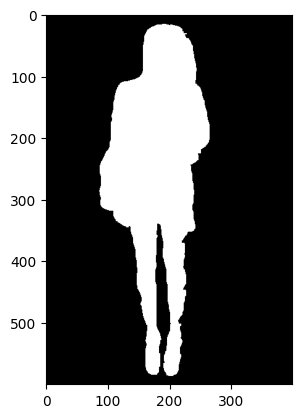

In [7]:
#example person label
print(example_person.shape)
plt.imshow(example_person[0], cmap='gray')

In [9]:
import torch
from torchvision import transforms
import random

class RandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
        img = sample['img']
        label = sample['label']
        if random.random() < self.p:

            img, label = img.flip(-1), label.flip(-1)  # flip both image and target
        return {'img': img, 'label': label}

class Normalize(torch.nn.Module):

    def __init__(self, mean, std, inplace=False):
        super().__init__()
        self.mean = torch.tensor(mean, dtype=torch.float32)[None, :, None, None]
        self.std = torch.tensor(std, dtype=torch.float32)[None, :, None, None]
        self.inplace = inplace

    def forward(self, sample):
        """
        Args:
            tensor (Tensor): Tensor image to be normalized.

        Returns:
            Tensor: Normalized Tensor image.
        """
        img = sample['img']
        label = sample['label']

        img = (img - self.mean) / self.std
        img = (img.float() - img.min())/ (img.max() - img.min())
        return img, label



In [10]:
class SegmentationDataset(Dataset):
    def __init__(self, imgs_path, labels_path, num_classes, d_type):
        self.imgs_path = imgs_path
        self.imgs = sorted(os.listdir(imgs_path))

        if '.DS_Store' in self.imgs[0]:
            self.imgs = self.imgs[1:]
        self.labels_path = labels_path

        self.labels = sorted(os.listdir(labels_path))
        if '.DS_Store' in self.labels[0]:
            self.labels = self.labels[1:]
        self.num_classes = num_classes
        self.d_type = d_type

    def __getitem__(self, idx):
        """ Get image and its corresponding label """

        img = read_image(os.path.join(self.imgs_path, self.imgs[idx]))
        label = read_image(os.path.join(self.labels_path, self.labels[idx]))

        sample = {'img': torch.tensor(img, dtype=torch.float32), 'label':  torch.tensor(label, dtype=torch.float32)}

        transformed_sample = self.transform(sample)
        return transformed_sample
    def transform(self, sample):
        if self.d_type == 'train':
            # Normalize image using mean and std computed from training images
            tr = transforms.Compose([
                RandomHorizontalFlip(p=0.5),
                Normalize(mean=[116.8729, 116.6654, 116.5676], std=[46.1540, 45.8564, 45.8698])
])


        elif self.d_type == 'test' or self.d_type == 'val':
          # Normalize image using mean and std computed from training images
            tr = transforms.Compose([
                Normalize(mean=[116.8729, 116.6654, 116.5676], std=[46.1540, 45.8564, 45.8698])
])


        return tr(sample)
    def __len__(self):
        return len(self.imgs)

In [11]:
train_data_person = SegmentationDataset("/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/images/", "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/labels_person/", num_classes=2, d_type='train')
train_data_clothing = SegmentationDataset("/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/images/", "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/labels_clothing/", num_classes=7, d_type='train')

val_data_person = SegmentationDataset("/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/val_images/", "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/val_labels_person/", num_classes=2, d_type='val')
val_data_clothing = SegmentationDataset("/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/val_images/", "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/val_labels_clothing/", num_classes=7, d_type='val')

test_data_person = SegmentationDataset("/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/test_images/", "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/test_labels_person/", num_classes=2, d_type='test')
test_data_clothing = SegmentationDataset("/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/test_images/", "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/test_labels_clothing/", num_classes=7, d_type='test')

In [12]:
def class_weights(data):
  data_length = len(data.imgs)
  loader = torch.utils.data.DataLoader(data, batch_size=16, shuffle=False)
  class_counts = np.zeros(7)
  for imgs, labels in loader:
    mask = (labels >= 0) & (labels < 7)
    # print(class_counts.shape)
    # print( np.bincount(np.bincount(labels[mask].cpu().numpy().astype(np.uint8), minlength=7)).shape)
    class_counts += np.bincount(labels[mask].cpu().numpy().astype(np.uint8), minlength=7)
  class_weights = 1 / (((class_counts / np.sum(class_counts))))
  return class_weights


In [13]:
print(len(train_data_person.imgs))
print(len(train_data_clothing.imgs))
print(len(val_data_person.imgs))
print(len(val_data_clothing.imgs))
print(len(test_data_person.imgs))
print(len(test_data_clothing.imgs))

480
480
60
60
60
60


In [17]:
print(val_data_clothing.__getitem__(12)[0].shape)

torch.Size([1, 3, 600, 400])


<ipython-input-10-ef04cbba7226>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = {'img': torch.tensor(img, dtype=torch.float32), 'label':  torch.tensor(label, dtype=torch.float32)}


In [15]:
img, label = train_data_clothing.__getitem__(310)

<ipython-input-10-ef04cbba7226>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = {'img': torch.tensor(img, dtype=torch.float32), 'label':  torch.tensor(label, dtype=torch.float32)}


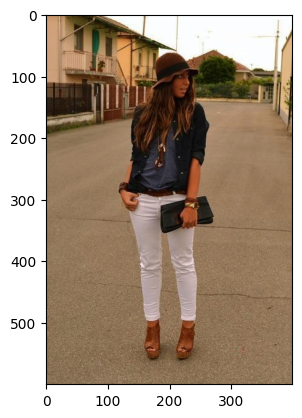

In [16]:
plt.imshow(img[0].permute(1,2,0))

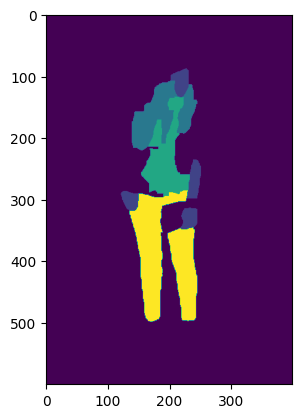

In [18]:
plt.imshow(label[0])

# Resnet Model

In [19]:
class ResidualBlockEncoder(nn.Module):
    expansion = 1
    def __init__(self, input_channels, out_channels, dilation, stride=1,
                 downsample=None):
        super(ResidualBlockEncoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=out_channels,\
                           kernel_size=3, stride=stride, padding=dilation, dilation=dilation)

        self.norm1 = nn.BatchNorm2d(num_features=out_channels)

        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels,\
                            kernel_size=3, stride=stride, padding=dilation, dilation=dilation)

        self.norm2 = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()
        self.downsample = downsample
    def forward(self, x):

        residual = x.clone()

        x = self.relu(self.norm1(self.conv1(x)))

        x = self.relu(self.norm2(self.conv2(x)))

        if self.downsample:
            residual = self.downsample(residual)


        x = x + residual
        x = self.relu(x)

        return x


In [22]:
class ResNetEncoder(nn.Module):
    def __init__(self, num_blocks, ResidualBlock, dilations, img_channels=3,
                 out_channels=16):
        super(ResNetEncoder, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=img_channels, out_channels=out_channels,\
                           kernel_size=3, stride=2, padding=1)
        self.norm1 = nn.BatchNorm2d(num_features=out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.layer_in_channels = out_channels
        self.layer1 = self._make_layer(ResidualBlock, num_blocks[0], dilations[0], out_channels=32)
        self.layer2 = self._make_layer(ResidualBlock, num_blocks[1], dilations[1], out_channels=64, stride=1)
        self.layer3 = self._make_layer(ResidualBlock, num_blocks[2], dilations[2], out_channels=128, stride=1)
        self.layer4 = self._make_layer(ResidualBlock, num_blocks[3], dilations[3], out_channels=256, stride=1)

        self.relu = nn.ReLU()

    def _make_layer(self, ResidualBlock, num_blocks, dilation, out_channels, stride=1):
        downsample = None
        if stride != 1 or self.layer_in_channels != out_channels * ResidualBlock.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.layer_in_channels, out_channels * ResidualBlock.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * ResidualBlock.expansion)
            )

        layer = []
        layer.append(ResidualBlock(self.layer_in_channels, out_channels, dilation, stride, downsample))
        self.layer_in_channels = out_channels * ResidualBlock.expansion

        for i in range(1, num_blocks):
            layer.append(ResidualBlock(self.layer_in_channels, out_channels, dilation, stride))

        return nn.Sequential(*layer)

    def forward(self, x):

        x = self.relu(self.norm1(self.conv1(x)))
        x = self.layer1(x)

        x_1 = x.clone()

        x = self.layer2(x)
        p2_shape = x.shape
        x_2 = x.clone()
        x, ind_2 = self.pool(x)

        x = self.layer3(x)

        x_3 = x.clone()

        x = self.layer4(x)
        p4_shape = x.shape
        x_4 = x.clone()
        x, ind_4 = self.pool(x)
        # Kept clones for additional connections between encoder and decoder
        # Will only be using last clone for now
        clones = [x_1, x_2, x_3, x_4]

        return x, ind_2, ind_4, p2_shape, p4_shape, clones


In [24]:
class Decoder(nn.Module):
    def __init__(self, num_blocks, num_classes,
                 encoder_out_channels=256):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU()
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2) # 512 x 150 x 100
        self.conv1 = nn.Conv2d(in_channels=encoder_out_channels, out_channels=256,\
                    kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(num_features=256)


        self.conv2 = nn.Conv2d(in_channels=256, out_channels=128,\
                    kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(num_features=128)



        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64,\
                    kernel_size=3, stride=1, padding=1)
        self.norm3 = nn.BatchNorm2d(num_features=64)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=32,\
                    kernel_size=3, stride=1, padding=1)
        self.norm4 = nn.BatchNorm2d(num_features=32)

        self.upsample = nn.Upsample(scale_factor=2, mode='bicubic')

        self.conv5 = nn.Conv2d(in_channels=32, out_channels=16,\
                    kernel_size=1, stride=1, padding=0)
        self.norm5 = nn.BatchNorm2d(num_features=16)

        self.conv6 = nn.Conv2d(in_channels=16, out_channels=num_classes,\
                    kernel_size=1, stride=1, padding=0)
        self.norm6 = nn.BatchNorm2d(num_features=num_classes)

    def forward(self, x, ind_2, ind_4, p2_shape, p4_shape, clones):

        x = self.unpool(x, ind_4)
        x = torch.cat((x, clones[3]), dim=1)

        x = self.relu(self.norm1(self.conv1(x)))
        x = self.relu(self.norm2(self.conv2(x)))
        x = self.relu(self.norm3(self.conv3(x)))

        x = self.unpool(x, ind_2)

        x = self.relu(self.norm4(self.conv4(x)))
        x = self.relu(self.norm5(self.conv5(x)))

        x = self.upsample(x)

        x = self.conv6(x)
        return x

In [25]:
class ImageSegmentation(nn.Module):
    def __init__(self, num_blocks, dilations, task):
        super(ImageSegmentation, self).__init__()
        num_classes = 7 if task == 'clothing' else 2
        img_channels = 5 if task == 'clothing' else 3

        self.encoder = ResNetEncoder(num_blocks, ResidualBlockEncoder, dilations, img_channels=img_channels)

        self.conv1 = nn.Conv2d(in_channels=256, out_channels=256,\
                    kernel_size=1, stride=1, padding=0)
        self.relu = nn.ReLU()

        self.decoder = Decoder(num_blocks, num_classes, encoder_out_channels=512)
        self.norm1 = nn.BatchNorm2d(num_features=256)

    def forward(self, x):

        x, ind_2, ind_4, p2_shape, p4_shape, clones = self.encoder(x)

        x = self.relu(self.norm1(self.conv1(x)))

        x = self.decoder(x, ind_2, ind_4, p2_shape, p4_shape, clones)

        return x
    def save(self, path):
        torch.save(self.encoder.state_dict(), '{}_encoder.pk'.format(path))
        torch.save(self.decoder.state_dict(), '{}_decoder.pk'.format(path))

    def load(self, path):
        self.encoder.load_state_dict(torch.load('{}_encoder.pk'.format(path)))
        self.decoder.load_state_dict(torch.load('{}_decoder.pk'.format(path)))

# Person Segmentation Training

In [ ]:
!pip install torchmetrics

In [27]:
from torchmetrics import JaccardIndex

In [39]:
def get_accuracy(model, data, num_classes, person_model=None):

    loader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=True)

    model.eval() # annotate model for evaluation

    correct = 0
    total = 0
    N = 0
    accs_list = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    jaccard = JaccardIndex(task="multiclass", num_classes=num_classes).to(device)
    iou_list = []

    if torch.cuda.is_available():
        model.cuda()
    i = 0
    for imgs, labels in loader:
        imgs = imgs.squeeze(1)
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        if num_classes > 2:
          person_outlines = person_model(imgs)

          imgs_outlined = torch.cat((imgs, person_outlines), dim=1)
          output = model(imgs_outlined)
        else:
          output = model(imgs)
        pred = output.argmax(1, keepdim=True)

        # Get number of correct pixel predictions
        correct = pred.eq(labels.view_as(pred)).sum().item()
        # IoU score
        iou = jaccard(pred, labels)
        iou_list.append(iou)

        acc = correct / (imgs.shape[2] * imgs.shape[3] * imgs.shape[0])
        accs_list.append(acc)

        i += 1
        if i == 1:
          print("Prediction", np.unique(pred.cpu().numpy(), return_counts=True))
          print("Target", np.unique(labels.cpu().numpy(), return_counts=True))
        del imgs
        del labels
        del output
        del pred
        if num_classes > 2:
          del imgs_outlined
          del person_outlines
        torch.cuda.empty_cache()
    # return average accuracy and iou over the dataset
    return sum(accs_list)/len(accs_list), sum(iou_list) / len(iou_list)

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

In [30]:
from segmentation_models_pytorch.losses import TverskyLoss

In [31]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [34]:
def train_person(train_data, valid_data, model, checkpoint_path, checkpoint_dir, num_classes, num_epochs=50, learning_rate=1e-3, batch_size=32,
          weight_decay=0, class_weights=None):
    train = torch.utils.data.DataLoader(train_data, batch_size=batch_size,\
                                        shuffle=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # class_weights=torch.tensor(class_weights, dtype=torch.float32).to(device)

    # criterion = nn.CrossEntropyLoss(weight=class_weights)
    criterion = TverskyLoss(smooth=1e-5, mode='multiclass', classes=7, from_logits=True, log_loss=True, gamma=0.75, alpha=0.6)

    if not os.path.exists(checkpoint_dir):
        os.mkdir(checkpoint_dir)
    epoch = 0
    train_accs, train_losses = [], []
    val_accs = []
    iters = []
    n = 0
    epochs = []
    val_ious = []
    train_ious = []
    batch_loss = 0

    if torch.cuda.is_available():
        model.cuda()
        criterion.cuda()
    optimizer = optim.Adam(model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True, threshold=0.001)
    while epoch < num_epochs:


        model.train()
        epoch_loss = 0
        for imgs, labels in train:
            imgs = imgs.squeeze(1)
            if imgs.shape[0] < batch_size:
                # Last batch will have less images since it will be the
                # remainder of Total images / batch_size.

                optimizer = optim.Adam(model.parameters(),
                                        lr=learning_rate * (imgs.shape[0] / batch_size),
                                        weight_decay=weight_decay)
            if torch.cuda.is_available():
                imgs = imgs.cuda()

            outputs = model(imgs)
            labels = labels.squeeze(dim=1).long()

            if torch.cuda.is_available():
                outputs = outputs.cuda()


            loss = criterion(outputs, labels.cuda())

            loss.backward()
            # accumulate gradients over 8 batches
            # Each batch is 2 images, update weights after 16 images
            # implemented to save gpu memory
            if n % 8 == 0:
              optimizer.step()
              optimizer.zero_grad()

            n += 1

            iters.append(n)
            # average loss
            train_losses.append(float(loss)/batch_size)
            epoch_loss += (float(loss) * batch_size)
            del imgs
            del labels
            del outputs
            torch.cuda.empty_cache()

        # end of epoch
        epoch += 1
        epochs.append(epoch)
        # Get train iou and accuracy
        train_acc, train_iou = get_accuracy(model, train_data, num_classes)
        train_accs.append(train_acc)

        train_ious.append(train_iou)

        # Get val iou and accuracy
        val_acc, val_iou = get_accuracy(model, valid_data, num_classes)
        val_accs.append(val_acc)

        val_ious.append(val_iou)
        scheduler.step(val_iou)

        print("--------------------------------------------------------------")
        print("Epochs: {}   Train Accuracy: {}   Train IOU: {}   Val Accuracy: {}   Val IOU: {}   Avg Epoch Loss: {}   LR: {}".format(epoch, train_acc, train_iou, val_acc, val_iou, epoch_loss/480, learning_rate))
        print("--------------------------------------------------------------")

        if epoch > 15:
          model.save(checkpoint_path.format(epoch))
    return iters, train_losses, epochs, train_accs, val_accs, train_ious, val_ious


In [35]:
person_checkpoint_path = "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/checkpoints/person_checkpoint/checkpoint-{}"
person_checkpoint_dir= "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/checkpoints/person_checkpoint"

In [36]:
img_size = train_data_person.__getitem__(1)[1].size()
num_blocks_person = [4, 4, 6, 8]
# num_blocks = [1, 1, 1, 1]
dilations_person = [1, 1, 1, 1]

<ipython-input-10-ef04cbba7226>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = {'img': torch.tensor(img, dtype=torch.float32), 'label':  torch.tensor(label, dtype=torch.float32)}


In [37]:
task = 'person'
model = ImageSegmentation(num_blocks=num_blocks_person, dilations=dilations_person, task=task)

In [ ]:
iters, train_losses, epochs, train_accs, val_accs, train_ious, val_ious = train_person(train_data_person,
                                                          val_data_person, model,
                                                          num_epochs=40,
                                                          learning_rate=0.001,
                                                          batch_size=2,
                                                          weight_decay=0,
                                                          checkpoint_path=person_checkpoint_path,
                                                          checkpoint_dir=person_checkpoint_dir,
                                                          num_classes=2,
                                                          class_weights=None)

# Clothing Segmentation Training

In [41]:
def clothing_train(person_model, train_data, valid_data, model, checkpoint_path, checkpoint_dir, num_classes, num_epochs=50, learning_rate=1e-3, batch_size=32,
          weight_decay=0, class_weights=None):
    train = torch.utils.data.DataLoader(train_data, batch_size=batch_size,\
                                        shuffle=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # class_weights=torch.tensor(class_weights, dtype=torch.float32).to(device)
    # criterion = nn.CrossEntropyLoss(weight=class_weights)
    criterion = TverskyLoss(smooth=1e-5, mode='multiclass', classes=7, from_logits=True, log_loss=True, gamma=0.75, alpha=0.6)

    if not os.path.exists(checkpoint_dir):
        os.mkdir(checkpoint_dir)
    epoch = 0
    train_accs, train_losses = [], []
    val_accs = []
    iters = []
    n = 0
    epochs = []
    val_ious = []
    train_ious = []
    batch_loss = 0

    if torch.cuda.is_available():
        model.cuda()
        criterion.cuda()
    optimizer = optim.Adam(model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True, threshold=0.001)
    while epoch < num_epochs:


        model.train()
        person_model.eval()
        person_model.to(device)
        epoch_loss = 0
        for imgs, labels in train:
            imgs = imgs.squeeze(1)
            imgs = torch.cat((imgs[:, :3, :, :], imgs[:, 6:, :, :]), dim=1)
            if imgs.shape[0] < batch_size:
                # Last batch will have less images since it will be the
                # remainder of Total images / batch_size.

                optimizer = optim.Adam(model.parameters(),
                                        lr=learning_rate * (imgs.shape[0] / batch_size),
                                        weight_decay=weight_decay)
            if torch.cuda.is_available():
                imgs = imgs.cuda()

            person_outlines = person_model(imgs)

            imgs_outlined = torch.cat((imgs, person_outlines), dim=1)

            outputs = model(imgs_outlined)
            labels = labels.squeeze(dim=1).long()

            if torch.cuda.is_available():
                outputs = outputs.cuda()


            loss = criterion(outputs, labels.cuda())

            loss.backward()
            if n % 8 == 0:
              optimizer.step()
              optimizer.zero_grad()

            n += 1

            iters.append(n)
            # average loss
            train_losses.append(float(loss)/batch_size)
            epoch_loss += (float(loss) * batch_size)
            del imgs
            del labels
            del outputs
            del person_outlines
            del imgs_outlined
            torch.cuda.empty_cache()

        # end of epoch
        epoch += 1
        epochs.append(epoch)
        train_acc, train_iou = get_accuracy(model, train_data, num_classes, person_model)
        train_accs.append(train_acc)

        train_ious.append(train_iou)


        val_acc, val_iou = get_accuracy(model, valid_data, num_classes, person_model)
        val_accs.append(val_acc)

        val_ious.append(val_iou)
        scheduler.step(val_iou)

        print("--------------------------------------------------------------")
        print("Epochs: {}   Train Accuracy: {}   Train IOU: {}   Val Accuracy: {}   Val IOU: {}   Avg Epoch Loss: {}   LR: {}".format(epoch, train_acc, train_iou, val_acc, val_iou, epoch_loss/480, learning_rate))
        print("--------------------------------------------------------------")

        if epoch > 15:
          model.save(checkpoint_path.format(epoch))
    return iters, train_losses, epochs, train_accs, val_accs, train_ious, val_ious


In [ ]:
img_size = train_data_person.__getitem__(1)[1].size()
num_blocks_clothing = [4, 6, 8, 8]
dilations_clothing = [1, 1, 2, 4]

In [43]:
task = 'clothing'
clothing_model = ImageSegmentation(num_blocks=num_blocks_clothing, dilations=dilations_clothing, task=task)

In [ ]:
weights = class_weights(train_data_clothing)

<ipython-input-10-ef04cbba7226>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = {'img': torch.tensor(img, dtype=torch.float32), 'label':  torch.tensor(label, dtype=torch.float32)}


In [281]:
weights

array([ 1.61118578, 17.77800545, 24.90766461, 22.91206335, 32.69424513,
       19.31812404, 19.64629267])

In [28]:
clothing_checkpoint_path= "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/checkpoints/clothing_checkpoint/checkpoint-{}"
clothing_checkpoint_dir= "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/checkpoints/clothing_checkpoint"

In [39]:
person_model = ImageSegmentation(num_blocks=num_blocks_person, dilations=dilations_person, task='person')

In [43]:
person_model.load("/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/checkpoints/person_checkpoint/checkpoint-1-1-1-1-dial-4-4-6-8-blocks40")

In [ ]:
iters, train_losses, epochs, train_accs, val_accs, train_ious, val_ious = clothing_train(person_model, train_data_clothing,
                                                          val_data_clothing, clothing_model,
                                                          num_epochs=60,
                                                          learning_rate=0.0005,
                                                          batch_size=2,
                                                          weight_decay=0,
                                                          checkpoint_path=clothing_checkpoint_path,
                                                          checkpoint_dir=clothing_checkpoint_dir,
                                                          num_classes=7,
                                                          class_weights=None)

In [21]:
from matplotlib import colors

In [25]:
def display_results(model, data, person_model, num_classes):

    loader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=True)

    model.eval() # annotate model for evaluation (why do we need to do this?)

    correct = 0
    total = 0
    N = 0

    if num_classes > 2:
      colours = colors.ListedColormap(['black', 'red', 'lightgreen', 'yellow', 'blue', 'purple', 'lightblue'])
    else:
      colours = 'gray'
    if torch.cuda.is_available():
        model.cuda()
    i = 0
    for imgs, labels in loader:
        imgs = imgs.squeeze(1)
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        if num_classes > 2:
          person_outlines = person_model(imgs)

          imgs_outlined = torch.cat((imgs, person_outlines), dim=1)

          output = model(imgs_outlined)
        else:
          output = model(imgs)

        pred = output.argmax(1, keepdim=True)

        i += 1
        plt.imshow(pred.cpu()[0, 0, :, :], cmap=colours)

        plt.show()
        plt.imshow(labels.cpu()[0, 0, :, :], cmap=colours, vmin=0, vmax=num_classes-1)

        plt.show()
        l = labels.clone()
        del imgs
        del labels
        del output
        torch.cuda.empty_cache()
        if i == 3:
          break
    return pred, l # TODO: return the model accuracy

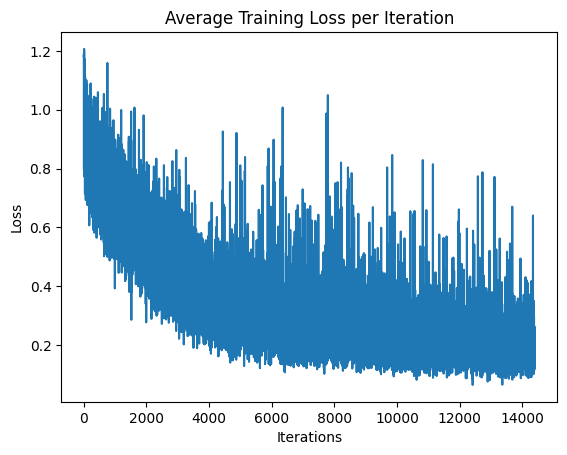

In [115]:
plt.plot(iters, train_losses)
plt.title("Average Training Loss per Iteration")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

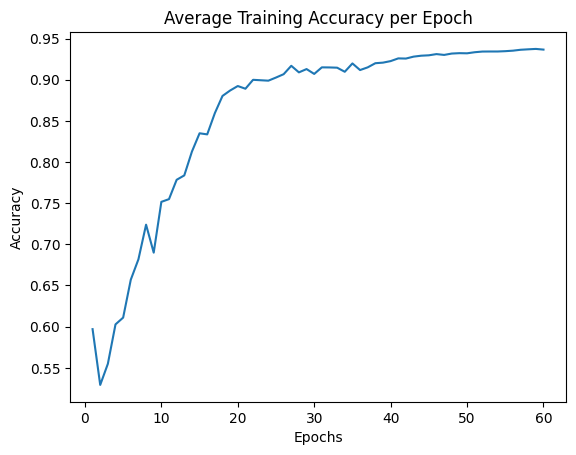

In [72]:
plt.plot(epochs, train_accs)
plt.title("Average Training Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [77]:
for i in range(len(train_ious)):
  train_ious[i] = train_ious[i].cpu()


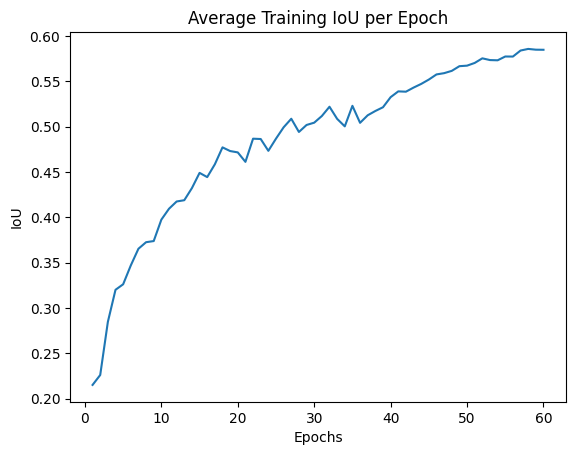

In [78]:
plt.plot(epochs, train_ious)
plt.title("Average Training IoU per Epoch")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.show()

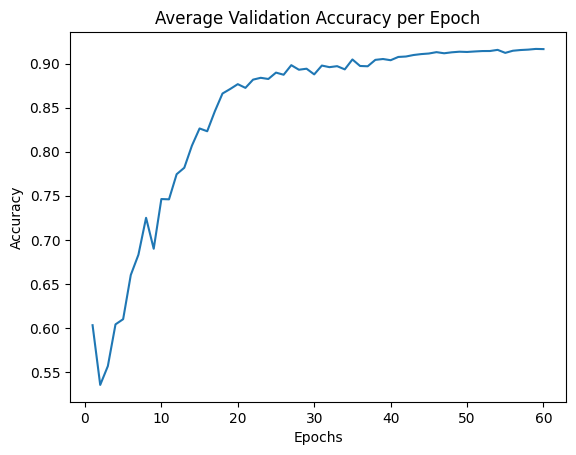

In [79]:
plt.plot(epochs, val_accs)
plt.title("Average Validation Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [80]:
for i in range(len(val_ious)):
  val_ious[i] = val_ious[i].cpu()

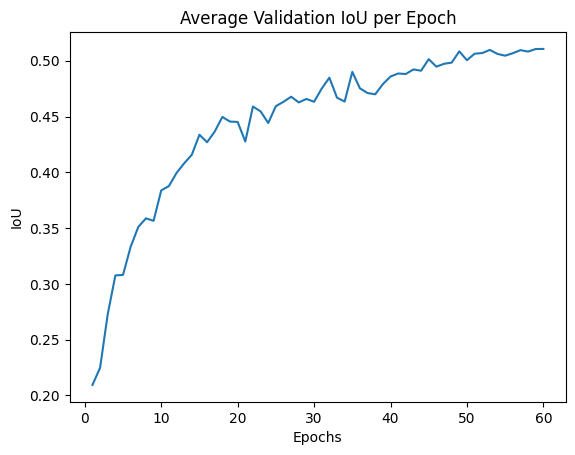

In [82]:
plt.plot(epochs, val_ious)
plt.title("Average Validation IoU per Epoch")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.show()

In [55]:
import pickle

In [56]:
filename = "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/metrics/iters-clothing.pkl"
with open(filename,"wb") as file:
  pickle.dump(iters, file)

In [57]:
filename = "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/metrics/epochs-clothing.pkl"
with open(filename,"wb") as file:
  pickle.dump(epochs, file)


In [58]:
filename = "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/metrics/train_accs-clothing.pkl"
with open(filename,"wb") as file:
  pickle.dump(train_accs, file)

In [59]:
filename = "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/metrics/train_losses-clothing.pkl"
with open(filename,"wb") as file:
  pickle.dump(train_losses, file)


In [60]:
filename = "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/metrics/val_accs-clothing.pkl"
with open(filename,"wb") as file:
  pickle.dump(val_accs, file)

In [61]:
filename = "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/metrics/val_ious-clothing.pkl"
with open(filename,"wb") as file:
  pickle.dump(val_ious, file)

In [62]:
filename = "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/metrics/train_ious-clothing.pkl"
with open(filename,"wb") as file:
  pickle.dump(train_ious, file)

## Person Segmentation Evaluation

In [16]:
num_blocks_person = [4, 4, 6, 8]
dilations_person = [1, 1, 1, 1]

In [18]:
person_model = ImageSegmentation(num_blocks=num_blocks_person, dilations=dilations_person, task='person')
person_model.load("/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/checkpoints/person_checkpoint/checkpoint-40")

<ipython-input-4-cc1fa98ec372>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = {'img': torch.tensor(img, dtype=torch.float32), 'label':  torch.tensor(label, dtype=torch.float32)}


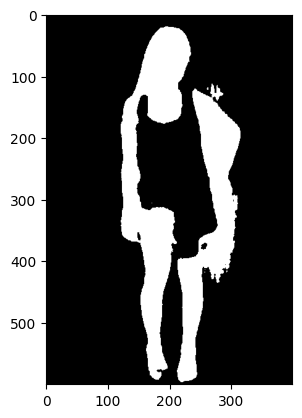

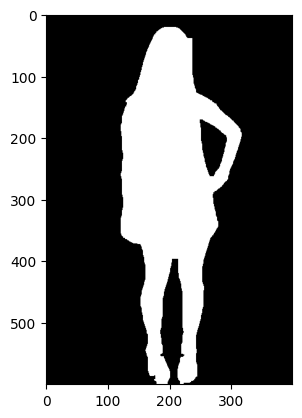

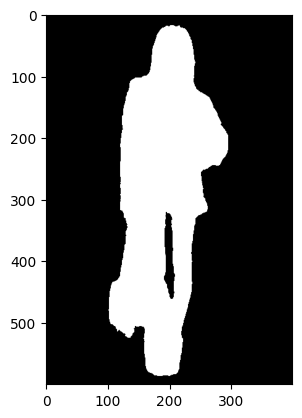

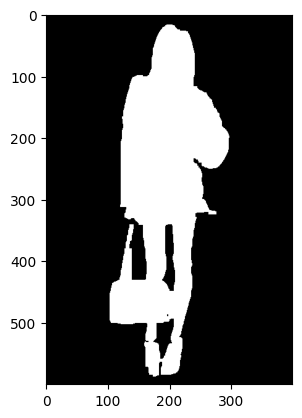

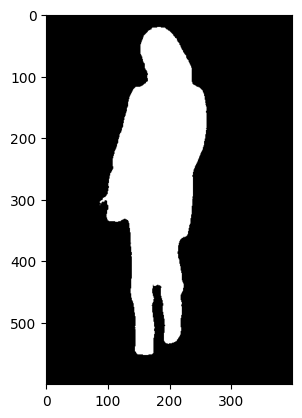

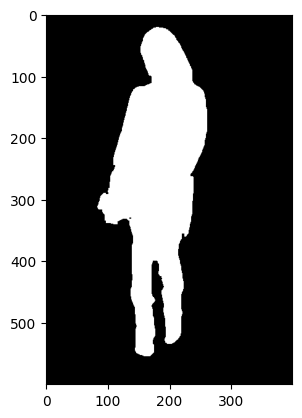

In [28]:
output, l = display_results(person_model, test_data_person, person_model, 2)

In [29]:
test_acc, test_iou = get_accuracy(person_model, test_data_person, 2, None)

<ipython-input-4-cc1fa98ec372>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = {'img': torch.tensor(img, dtype=torch.float32), 'label':  torch.tensor(label, dtype=torch.float32)}


Prediction (array([0, 1]), array([176198,  63802]))
Target (array([0., 1.], dtype=float32), array([171725,  68275]))


In [30]:
print(test_acc)
print(test_iou)

0.9516154166666666
tensor(0.8810, device='cuda:0')


# Clothing Segmentation Evaluation

<ipython-input-4-cc1fa98ec372>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = {'img': torch.tensor(img, dtype=torch.float32), 'label':  torch.tensor(label, dtype=torch.float32)}


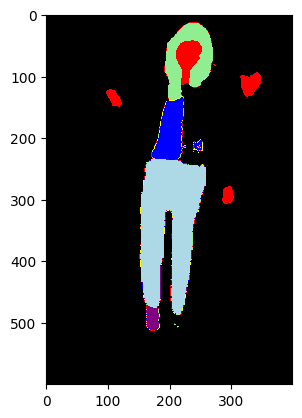

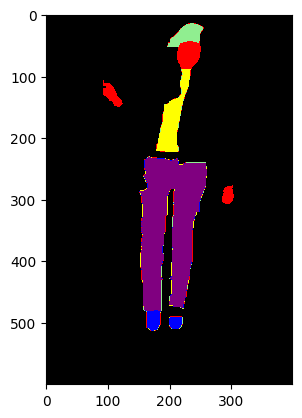

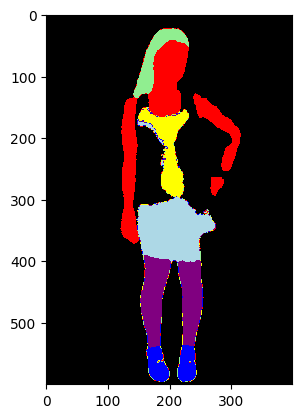

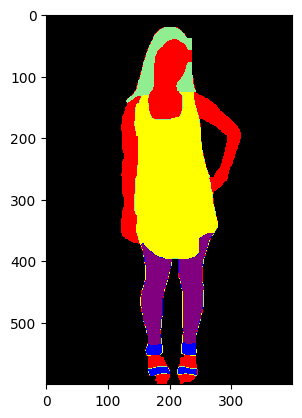

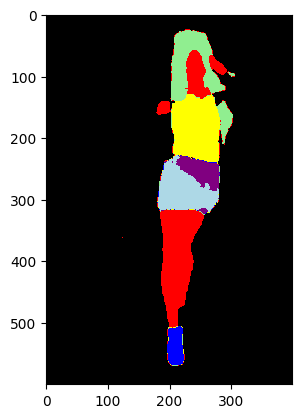

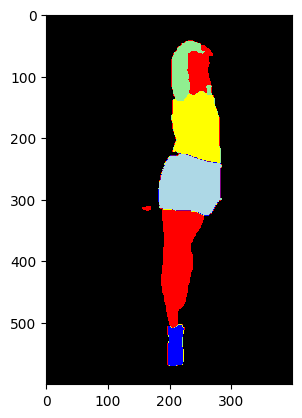

In [114]:
output, l = display_results(clothing_model, test_data_clothing, person_model, 7)

In [97]:
test_acc, test_iou = get_accuracy(clothing_model, test_data_clothing, 7, person_model)

<ipython-input-4-cc1fa98ec372>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = {'img': torch.tensor(img, dtype=torch.float32), 'label':  torch.tensor(label, dtype=torch.float32)}


Prediction (array([0, 1, 2, 4, 5, 6]), array([194085,  13050,   1295,   3970,    112,  27488]))
Target (array([0., 1., 2., 3., 4., 6.], dtype=float32), array([164604,  14595,    718,   4266,   4040,  51777]))


In [109]:
test_acc

0.9077259722222222

In [110]:
test_iou

tensor(0.5080, device='cuda:0')